In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")
import librosa

import torch
from transformers import AutoFeatureExtractor, AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

plt.ion()   # interactive mode

In [2]:
# Constants
AUDIORATE = 16000

### Define Dataset

In [3]:
class MMSERDataset(Dataset):
    """multi model ser dataset."""
    
    def __load_audio__(self, fn_path):
        # load all spectrogram
        self.fn_list = list(self.df_["smp_id"])
        self.raw_dict = {}
        for fn in self.fn_list[:1000]:
            self.raw_dict[fn] = wavfile.read(os.path.join(fn_path, fn)+'.wav')[1]
        self.raw_list = list(self.raw_dict.values())
        
    def __load_label__(self, cutmap_path):
        sheet_df = pd.DataFrame()
        for ses in range(1, 6):
            extractionmapPATH = cutmap_path + \
                str(ses)+'.xlsx'
            xl = pd.ExcelFile(extractionmapPATH)
            sheets = xl.sheet_names
            for sheet in sheets:
                sheet_df = pd.concat([sheet_df, xl.parse(sheet)])
        self.df_ = sheet_df.reset_index(drop=True)
        self.df_ = pd.merge(self.df_, self.df_text, on=["smp_id"])
        self.labels = list(self.df_["emotion"].unique())
        self.label2id = {label: i for i, label in enumerate(self.labels)}
        self.id2label = {i: label for i, label in enumerate(self.labels)}
        self.df_["emotion_id"] = self.df_["emotion"].map(self.label2id)
        
    def __load_text__(self, text_path):
        self.df_text = pd.read_csv(text_path)
        pass
    
    def __build_features__(self):
        self.input_features = self.audio_processer(self.raw_list, sampling_rate=AUDIORATE, return_tensors="pt")['input_features']
    
    def __init__(self, 
                 fn_path, 
                 cutmap_path, 
                 text_path, 
                 pretrained_model="openai/whisper-large"):
        self.audio_processer = AutoProcessor.from_pretrained(pretrained_model)
#         self.audio_encoder = WhisperForConditionalGeneration.from_pretrained(pretrained_model)
        self.__load_text__(text_path)
        self.__load_label__(cutmap_path)
        self.__load_audio__(fn_path)
        self.__build_features__()
        
    def __len__(self):
        return self.input_features.shape[0]
    
    def __getitem__(self, idx):
        return {
            "fn": self.fn_list[idx],
            "raw": self.raw_list[idx],
            "input_features": self.input_features[idx],
            "text": self.df_["transcript"][idx],
            "labels": self.df_["emotion_id"][idx]
        }

### Dataset Init

In [4]:
mmser_ds = MMSERDataset(fn_path = "E:/datasets/preprocessed/spectrogram/raw", 
                        cutmap_path = 'E:/datasets/preprocessed/extractionmap/cut_extractionmap', 
                        text_path = "E:/datasets/preprocessed/transcipt/transcript.csv")

### Check label

In [5]:
mmser_ds.df_['smp_id'].nunique()
print(len(mmser_ds))

1000


In [6]:
mmser_ds[777]

{'fn': 'Ses01F_script03_1_M038',
 'raw': array([ 41,  28,  22, ..., -13,  -2, -10], dtype=int16),
 'input_features': tensor([[2.1509, 2.5110, 2.6361,  ..., 1.3336, 1.3336, 1.3336],
         [2.1610, 2.4542, 2.5542,  ..., 1.3336, 1.3336, 1.3336],
         [1.9874, 2.3966, 2.3819,  ..., 1.3336, 1.3336, 1.3336],
         ...,
         [1.3336, 1.3336, 1.3336,  ..., 1.3336, 1.3336, 1.3336],
         [1.3336, 1.3336, 1.3336,  ..., 1.3336, 1.3336, 1.3336],
         [1.3336, 1.3336, 1.3336,  ..., 1.3336, 1.3336, 1.3336]]),
 'text': 'However I believe the real cause of that row was Peter Burden.',
 'labels': 2}

### Test Output

In [8]:
IDX=868
input_features = torch.tensor([mmser_ds[IDX]['input_features'].tolist()]).to(torch.float32)

# generated_ids = mmser_ds.audio_encoder.generate(inputs=input_features)
# transcription = mmser_ds.audio_processer.batch_decode(generated_ids, skip_special_tokens=True)[0]
# transcription

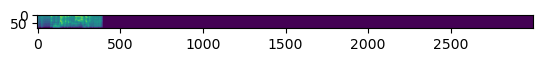

In [9]:
plt.imshow(mmser_ds[IDX]["input_features"])

### Save Dataset

In [10]:
torch.save(mmser_ds, "E:/datasets/preprocessed/dataset/mmser_ds.pt")